In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile
from skimage import measure
import argparse
import imutils
from PIL import Image
import seaborn as sns

# Import Data Set

In [3]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')

In [4]:
train_all_input = 'train_input_img/'+train_csv['input_img']
train_all_label = 'train_label_img/'+train_csv['label_img']
test_input_files = 'test_input_img/'+test_csv['input_img']

In [5]:
# subset 90% of train dataset as train set
train_input_files = train_all_input[62:].to_numpy()
train_label_files = train_all_label[62:].to_numpy()
# subset 10% of train dataset as validation set
val_input_files = train_all_input[:62].to_numpy()
val_label_files = train_all_label[:62].to_numpy()

In [6]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Reshape, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np


In [7]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (256, 256, 1))
    return img

In [8]:
train_set = []
test_set = []
train_cleaned = []
for i in train_input_files:
    train_set.append(process_image(i))
for i in test_input_files:
    test_set.append(process_image(i))
for i in train_label_files:
    train_cleaned.append(process_image(i))

In [9]:
len(train_set)

560

In [10]:
X_train = np.asarray(train_set)
X_test = np.asarray(test_set)
Y_train = np.asarray(train_cleaned)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [12]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(476, 256, 256, 1)
(84, 256, 256, 1)
(476, 256, 256, 1)
(84, 256, 256, 1)


## Autoencoder

autoencoder does not reduce the noise around lights, but it makes the images more clear.

In [13]:
import tensorflow
input_layer = tensorflow.keras.layers.Input(shape=(256, 256, 1))
encoder = tensorflow.keras.layers.Conv2D(32, 3, strides=2, padding="same", activation='relu')(input_layer)
encoder = tensorflow.keras.layers.Conv2D(64, 3, strides=2, padding="same", activation='relu')(encoder)
encoder = tensorflow.keras.layers.Conv2D(128, 3, strides=2, padding="same", activation='relu')(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

decoder = Dense(128)(encoder)
#decoder = Reshape((32, 32, 128))(decoder)
#Model(input_layer, decoder).summary()
decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation='relu')(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation='relu')(decoder)
decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder)


2022-11-27 00:09:52.186572: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-27 00:09:52.186734: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
autoencoder = Model(input_layer, decoder_output)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
dense (Dense)                (None, 32, 32, 16)        2064      
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 128)       2176      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 64, 64, 64)        73792 

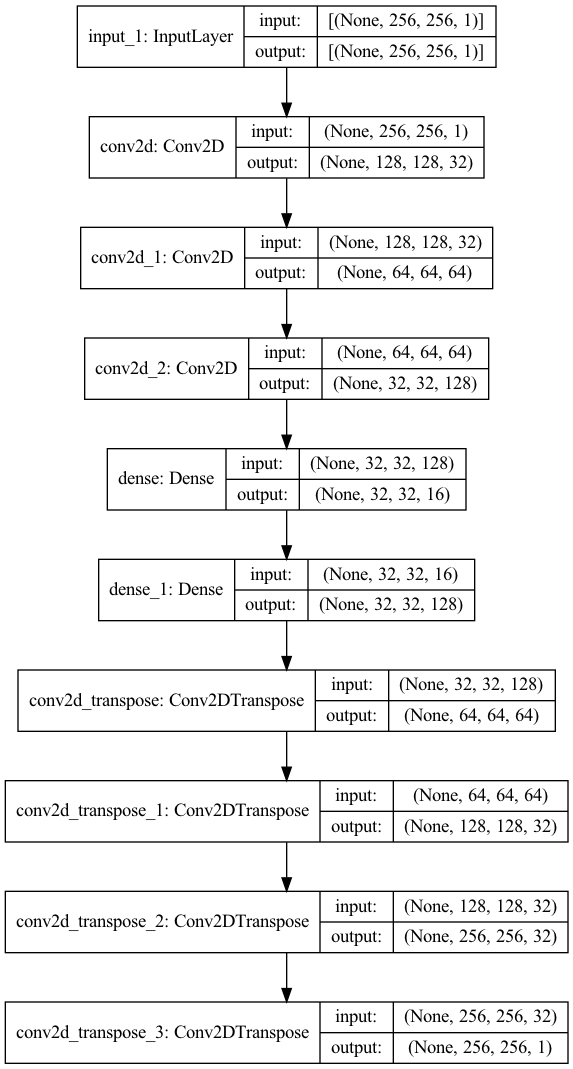

In [15]:
plot_model(autoencoder, to_file='model1.png',show_shapes=True)

In [16]:
autoencoder.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mae'])
callback = EarlyStopping(monitor='loss', patience=30)
history = autoencoder.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])

2022-11-27 00:10:17.115321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
20/20 [==============================] - 18s 875ms/step - loss: 0.1325 - mae: 0.3386 - val_loss: 0.0282 - val_mae: 0.1093
Epoch 2/10
20/20 [==============================] - 17s 833ms/step - loss: 0.0254 - mae: 0.1114 - val_loss: 0.0195 - val_mae: 0.1029
Epoch 3/10
20/20 [==============================] - 17s 829ms/step - loss: 0.0146 - mae: 0.0814 - val_loss: 0.0114 - val_mae: 0.0627
Epoch 4/10
20/20 [==============================] - 17s 837ms/step - loss: 0.0114 - mae: 0.0647 - val_loss: 0.0112 - val_mae: 0.0618
Epoch 5/10
20/20 [==============================] - 17s 859ms/step - loss: 0.0109 - mae: 0.0621 - val_loss: 0.0112 - val_mae: 0.0648
Epoch 6/10
20/20 [==============================] - 17s 844ms/step - loss: 0.0103 - mae: 0.0599 - val_loss: 0.0098 - val_mae: 0.0571
Epoch 7/10
20/20 [==============================] - 17s 869ms/step - loss: 0.0096 - mae: 0.0563 - val_loss: 0.0089 - val_mae: 0.0523
Epoch 8/10
20/20 [==============================] - 18s 886ms/step - 

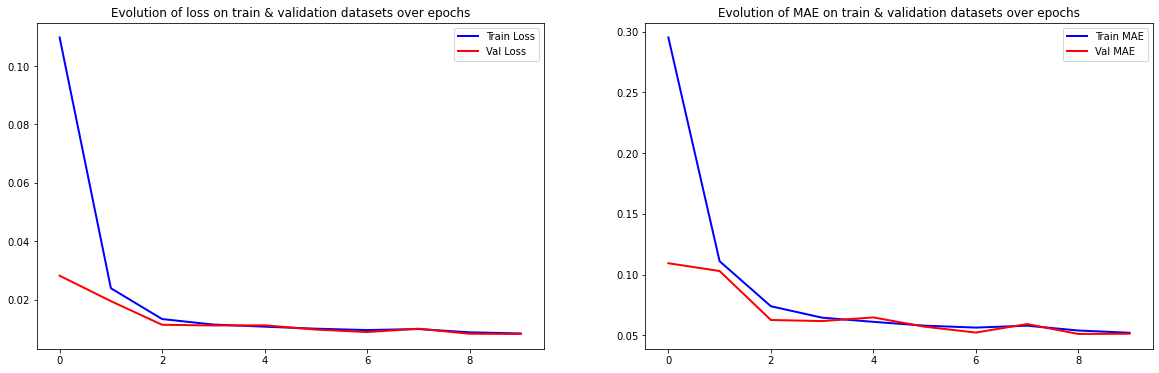

In [17]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [18]:
Y_test = autoencoder.predict(X_test, batch_size = 16)

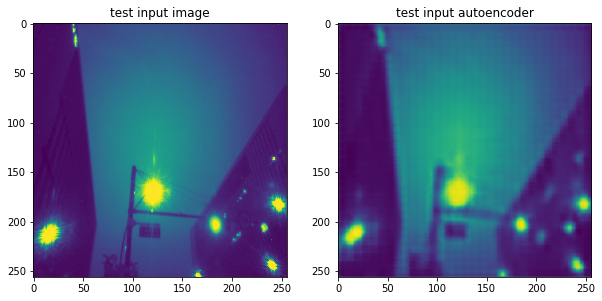

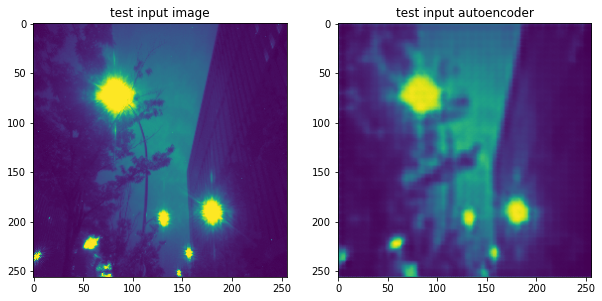

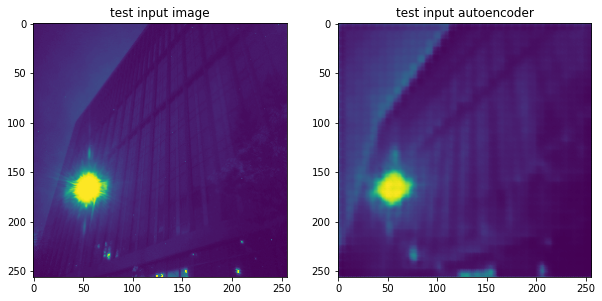

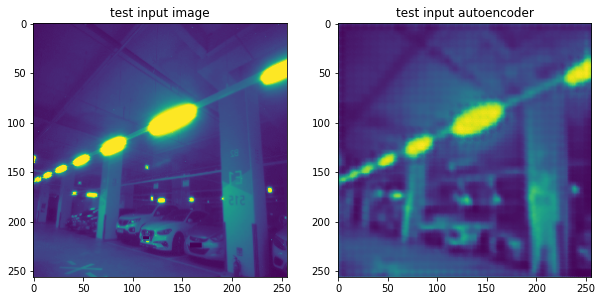

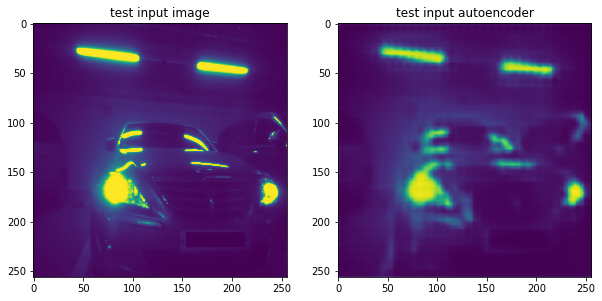

In [19]:
# plots
for i in range(10, 15):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 7.2))
    fig.add_subplot(121)
    plt.title('test input image')
    plt.imshow(X_test[i])
    fig.add_subplot(122)
    plt.title('test input autoencoder')
    plt.imshow(Y_test[i]) 
    plt.show

## autoencoder with maxpooling

when maxpooling is used, the the dimension is reduced and it returns the faster model fit, but it returns a blurry results
Dense(32) returns similar results. 

In [27]:
import tensorflow


input_layer = tensorflow.keras.layers.Input(shape=(256, 256, 1))
encoder = tensorflow.keras.layers.Conv2D(32, 3, padding="same", activation='relu')(input_layer)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(64, 3, padding="same", activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(128, 3, padding="same", activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

decoder = Dense(128)(encoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(128, 3,  padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3, padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder)


In [28]:
autoencoder2 = Model(input_layer, decoder_output)

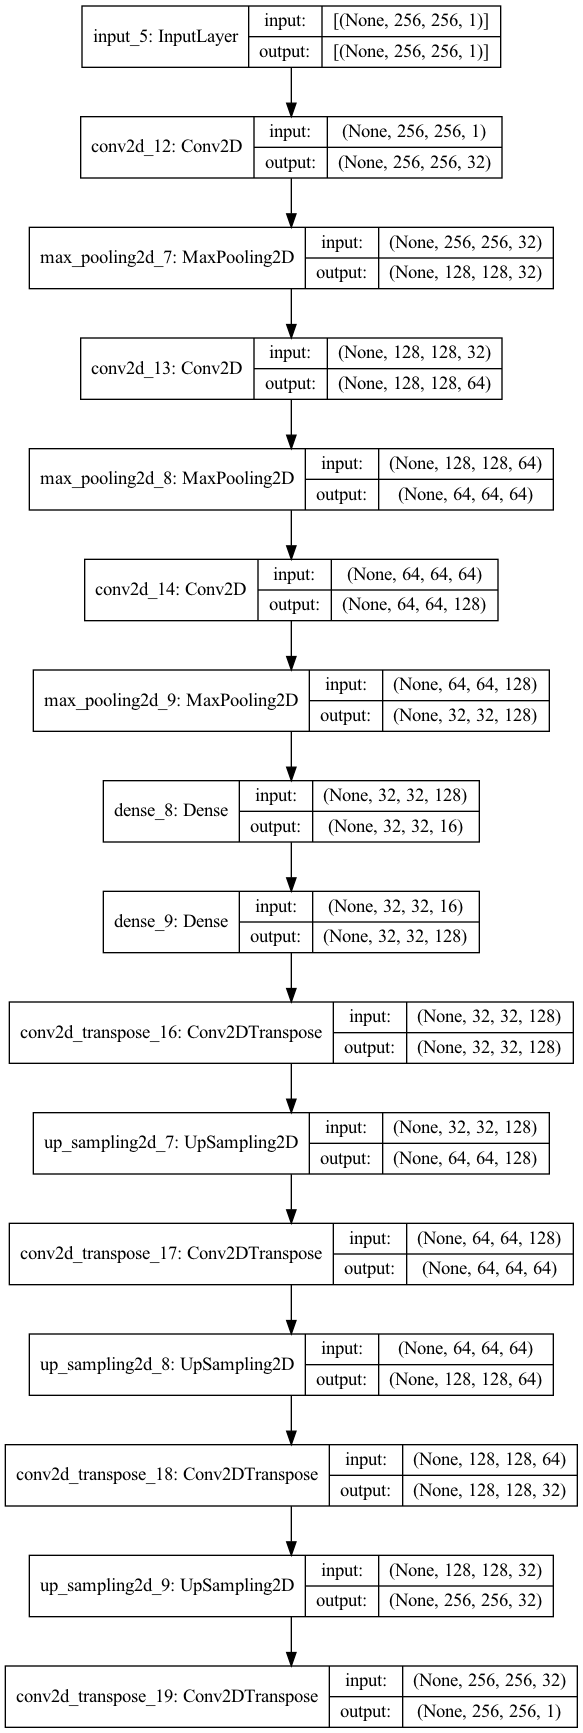

In [29]:
plot_model(autoencoder2, to_file='model2.png',show_shapes=True)

In [30]:
autoencoder2.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mae'])
callback = EarlyStopping(monitor='loss', patience=30)
history2 = autoencoder2.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])

Epoch 1/10
20/20 [==============================] - 35s 2s/step - loss: 0.1008 - mae: 0.2660 - val_loss: 0.0220 - val_mae: 0.1085
Epoch 2/10
20/20 [==============================] - 35s 2s/step - loss: 0.0183 - mae: 0.0897 - val_loss: 0.0176 - val_mae: 0.0877
Epoch 3/10
20/20 [==============================] - 35s 2s/step - loss: 0.0147 - mae: 0.0751 - val_loss: 0.0125 - val_mae: 0.0679
Epoch 4/10
20/20 [==============================] - 35s 2s/step - loss: 0.0118 - mae: 0.0654 - val_loss: 0.0110 - val_mae: 0.0613
Epoch 5/10
20/20 [==============================] - 36s 2s/step - loss: 0.0103 - mae: 0.0601 - val_loss: 0.0098 - val_mae: 0.0559
Epoch 6/10
20/20 [==============================] - 37s 2s/step - loss: 0.0106 - mae: 0.0611 - val_loss: 0.0117 - val_mae: 0.0640
Epoch 7/10
20/20 [==============================] - 36s 2s/step - loss: 0.0096 - mae: 0.0574 - val_loss: 0.0100 - val_mae: 0.0656
Epoch 8/10
20/20 [==============================] - 37s 2s/step - loss: 0.0092 - mae: 0.05

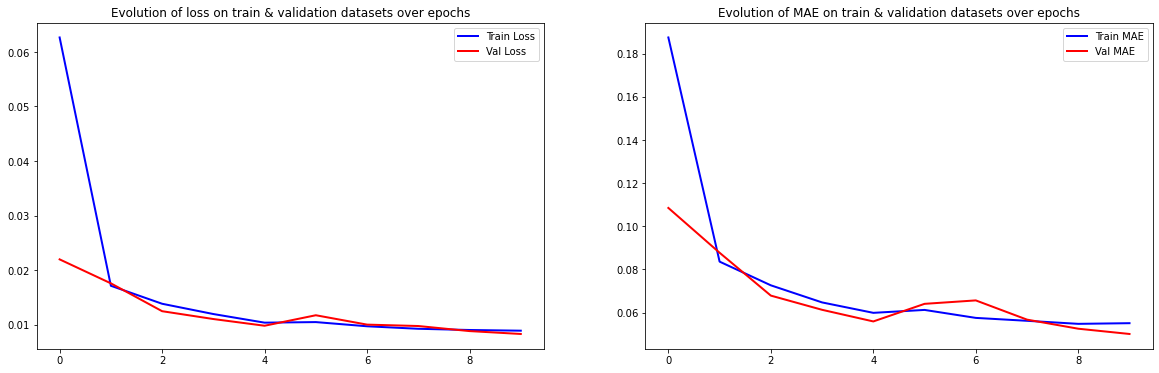

In [31]:
epoch_loss = history2.history['loss']
epoch_val_loss = history2.history['val_loss']
epoch_mae = history2.history['mae']
epoch_val_mae = history2.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [32]:
Y_test2 = autoencoder2.predict(X_test)

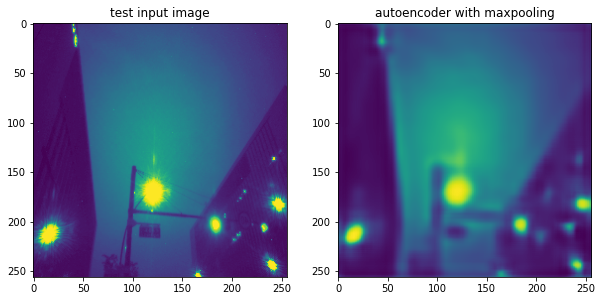

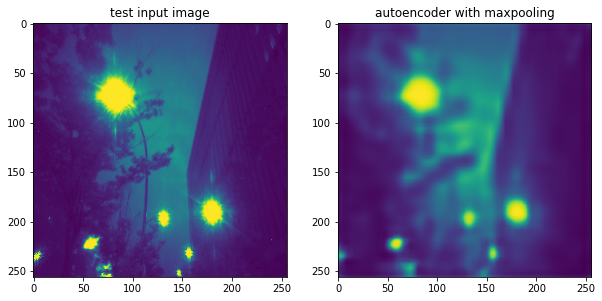

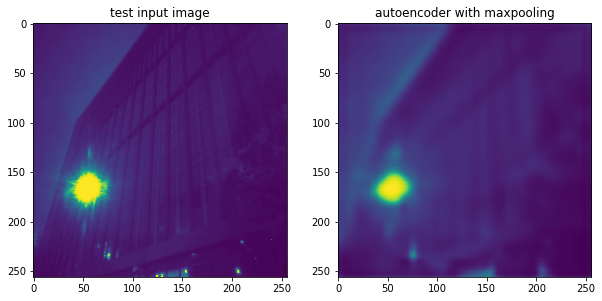

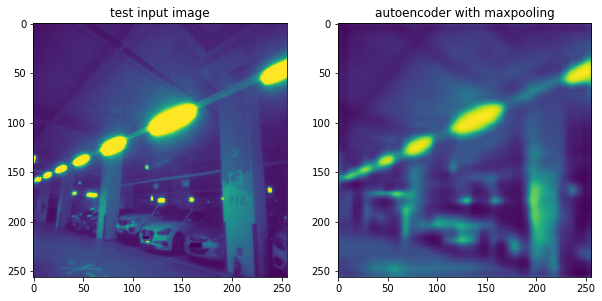

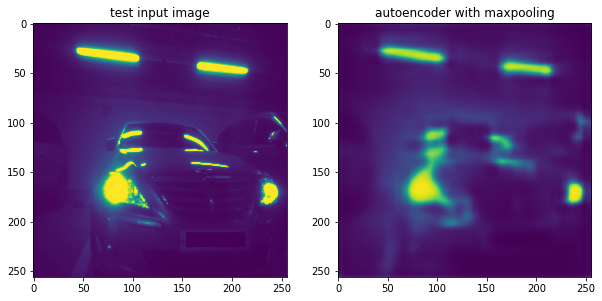

In [33]:
# plots
for i in range(10, 15):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 7.2))
    fig.add_subplot(121)
    plt.title('test input image')
    plt.imshow(X_test[i])
    fig.add_subplot(122)
    plt.title('autoencoder with maxpooling')
    plt.imshow(Y_test2[i])
    plt.show

## autodencoder maxpooling and dropout

In [34]:
import tensorflow
input_layer = tensorflow.keras.layers.Input(shape=(256, 256, 1))
encoder = tensorflow.keras.layers.Conv2D(32, 3, padding="same", activation='relu')(input_layer)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(64, 3, padding="same", activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(128, 3, padding="same", activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = Dropout(0.5)(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

decoder = Dense(128)(encoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(128, 3,  padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3, padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder)

In [35]:
autoencoder3 = Model(input_layer, decoder_output)

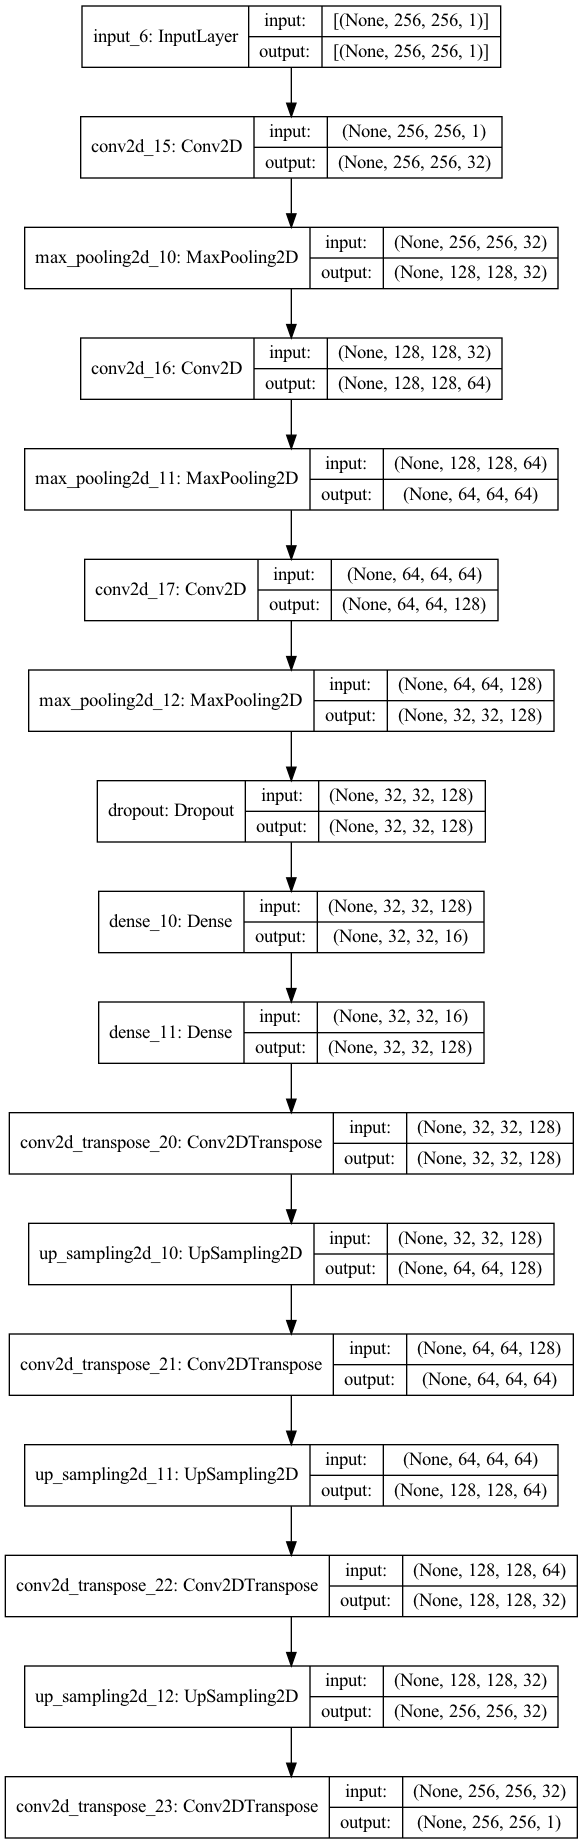

In [36]:
plot_model(autoencoder3, to_file='model3.png',show_shapes=True)

In [37]:
autoencoder3.compile(optimizer = 'adam', loss='mean_squared_error', metrics=['mae'])
callback = EarlyStopping(monitor='loss', patience=30)
history3 = autoencoder2.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])

Epoch 1/10
20/20 [==============================] - 38s 2s/step - loss: 0.0083 - mae: 0.0523 - val_loss: 0.0088 - val_mae: 0.0546
Epoch 2/10
20/20 [==============================] - 39s 2s/step - loss: 0.0084 - mae: 0.0538 - val_loss: 0.0083 - val_mae: 0.0515
Epoch 3/10
20/20 [==============================] - 39s 2s/step - loss: 0.0079 - mae: 0.0507 - val_loss: 0.0080 - val_mae: 0.0491
Epoch 4/10
20/20 [==============================] - 41s 2s/step - loss: 0.0081 - mae: 0.0518 - val_loss: 0.0078 - val_mae: 0.0522
Epoch 5/10
20/20 [==============================] - 40s 2s/step - loss: 0.0079 - mae: 0.0516 - val_loss: 0.0075 - val_mae: 0.0477
Epoch 6/10
20/20 [==============================] - 43s 2s/step - loss: 0.0080 - mae: 0.0520 - val_loss: 0.0076 - val_mae: 0.0471
Epoch 7/10
20/20 [==============================] - 45s 2s/step - loss: 0.0077 - mae: 0.0502 - val_loss: 0.0073 - val_mae: 0.0465
Epoch 8/10
20/20 [==============================] - 41s 2s/step - loss: 0.0079 - mae: 0.05

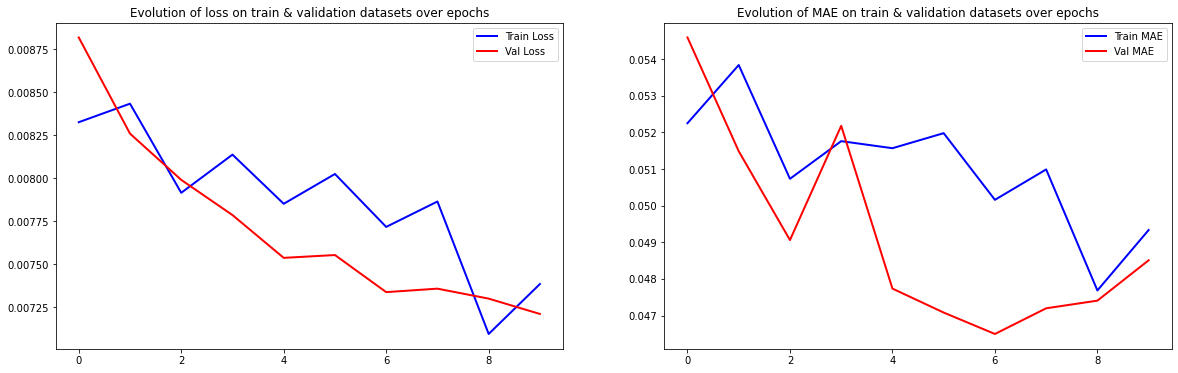

In [38]:
epoch_loss = history3.history['loss']
epoch_val_loss = history3.history['val_loss']
epoch_mae = history3.history['mae']
epoch_val_mae = history3.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [39]:
Y_test3 = autoencoder3.predict(X_test)

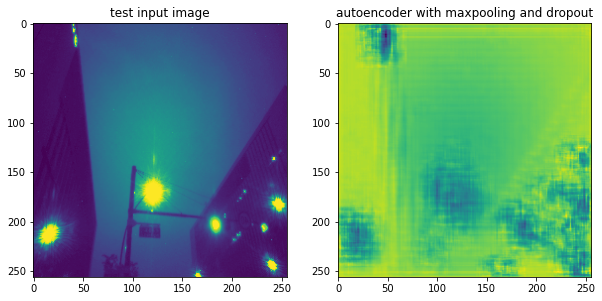

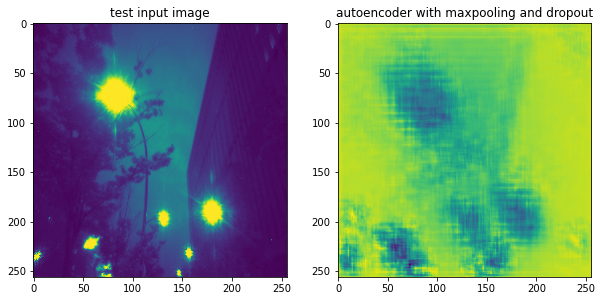

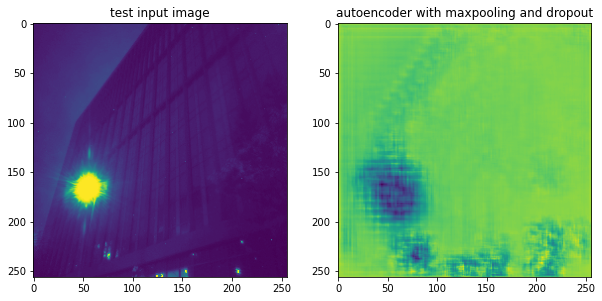

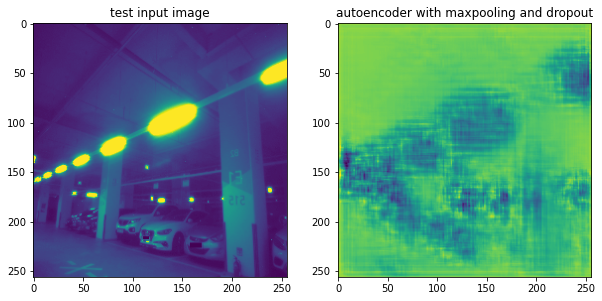

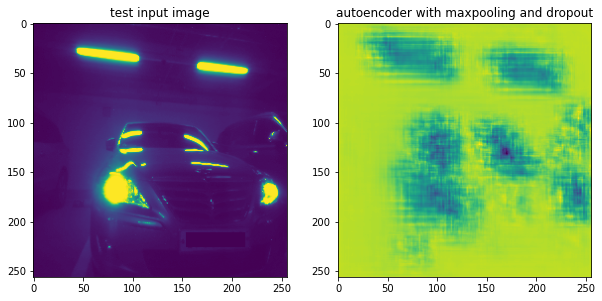

In [40]:
# plots
for i in range(10, 15):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 7.2))
    fig.add_subplot(121)
    plt.title('test input image')
    plt.imshow(X_test[i])
    fig.add_subplot(122)
    plt.title('autoencoder with maxpooling and dropout')
    plt.imshow(Y_test3[i])
    plt.show

## Autoencoder with Gaussian noise

In [41]:
# Model configuration
img_width, img_height = 256, 256
batch_size = 20
no_epochs = 10
verbosity = 1
max_norm_value = 2.0
noise_factor = 0.3
number_of_visualizations = 6

In [42]:
# add noise
pure = X_train
pure_test = X_test
noise = np.random.normal(0, 1, pure.shape)
noise_test = np.random.normal(0, 1, pure_test.shape)
noisy_input = pure + noise_factor * noise
noisy_input_test = pure_test + noise_factor * noise_test

In [43]:
pure = X_train
pure_test = X_test

In [44]:
input_layer = tensorflow.keras.layers.Input(shape=(256, 256, 1))
encoder = tensorflow.keras.layers.Conv2D(32, 3, padding="same", activation='relu')(input_layer)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(64, 3, padding="same", activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Conv2D(128, 3, padding="same", activation='relu')(encoder)
encoder = MaxPooling2D((2,2))(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

decoder = Dense(128)(encoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(128, 3,  padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3, padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, padding="same", activation='relu')(decoder)
decoder = UpSampling2D((2,2))(decoder)
decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 128)       0   

In [45]:
ae_withGnoise = Model(input_layer, decoder_output)
ae_withGnoise.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])


In [46]:
ae_withGnoise.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 128)       0   

In [48]:
callback = EarlyStopping(monitor='loss', patience=30)
history = ae_withGnoise.fit(noisy_input, pure, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])

Epoch 1/10
20/20 [==============================] - 35s 2s/step - loss: 0.1030 - mae: 0.2461 - val_loss: 0.1029 - val_mae: 0.3040
Epoch 2/10
20/20 [==============================] - 34s 2s/step - loss: 0.0237 - mae: 0.0978 - val_loss: 0.1177 - val_mae: 0.3207
Epoch 3/10
20/20 [==============================] - 36s 2s/step - loss: 0.0085 - mae: 0.0489 - val_loss: 0.1293 - val_mae: 0.3363
Epoch 4/10
20/20 [==============================] - 35s 2s/step - loss: 0.0059 - mae: 0.0455 - val_loss: 0.1100 - val_mae: 0.3087
Epoch 5/10
20/20 [==============================] - 35s 2s/step - loss: 0.0047 - mae: 0.0401 - val_loss: 0.1060 - val_mae: 0.3007
Epoch 6/10
20/20 [==============================] - 35s 2s/step - loss: 0.0034 - mae: 0.0310 - val_loss: 0.1021 - val_mae: 0.2958
Epoch 7/10
20/20 [==============================] - 35s 2s/step - loss: 0.0031 - mae: 0.0288 - val_loss: 0.0982 - val_mae: 0.2900
Epoch 8/10
20/20 [==============================] - 36s 2s/step - loss: 0.0027 - mae: 0.02

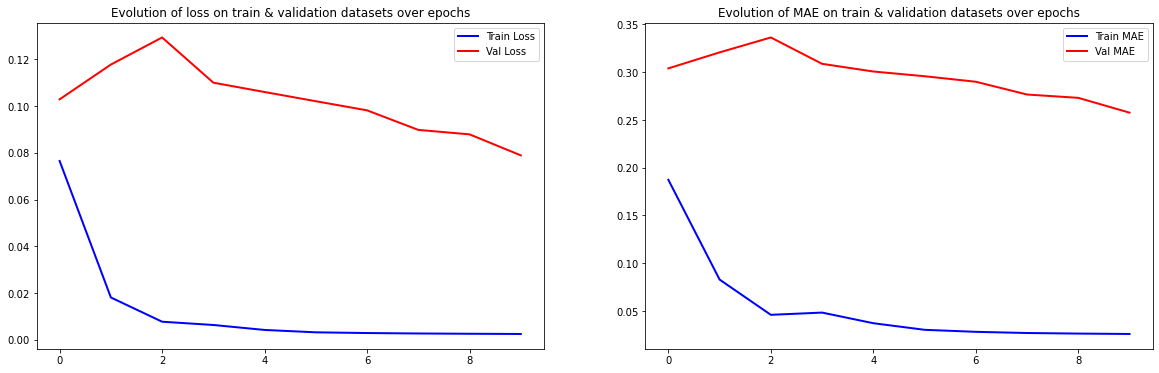

In [49]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

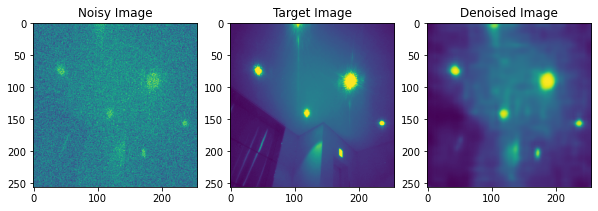

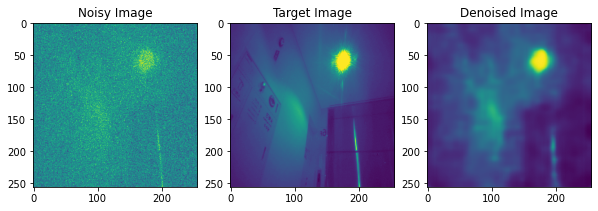

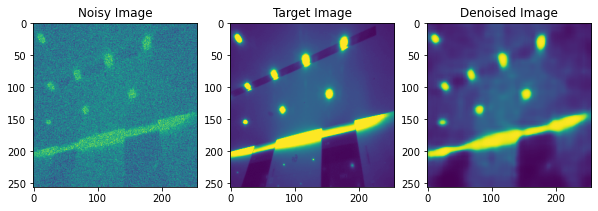

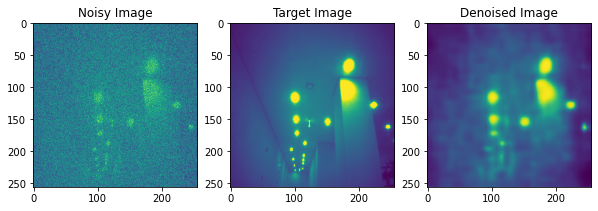

In [52]:
samples = noisy_input_test
targets = X_test
denoised_images = ae_withGnoise.predict(samples)
# plots
for i in range(0, 4):
    fig = plt.figure(figsize = (10, 9.2))
    fig.add_subplot(131)
    plt.title('Noisy Image')
    plt.imshow(samples[i])
    fig.add_subplot(132)
    plt.title('Target Image')
    plt.imshow(targets[i])
    fig.add_subplot(133)
    plt.title('Denoised Image')
    plt.imshow(denoised_images[i])
    plt.show

In [ ]:
# to fix the underfit 

## with dropout layer

In [53]:
def ae_dropout():
    
    encoder = tensorflow.keras.layers.Conv2D(32, 3, padding="same", activation='relu')(input_layer)
    encoder = MaxPooling2D((2,2))(encoder)
    encoder = tensorflow.keras.layers.Conv2D(64, 3, padding="same", activation='relu')(encoder)
    encoder = MaxPooling2D((2,2))(encoder)
    encoder = tensorflow.keras.layers.Conv2D(128, 3, padding="same", activation='relu')(encoder)
    encoder = MaxPooling2D((2,2))(encoder)
    encoder = Dropout(0.5)(encoder)
    encoder = tensorflow.keras.layers.Dense(16)(encoder)

    decoder = Dense(128)(encoder)
    decoder = tensorflow.keras.layers.Conv2DTranspose(128, 3,  padding="same", activation='relu')(decoder)
    decoder = UpSampling2D((2,2))(decoder)
    decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3, padding="same", activation='relu')(decoder)
    decoder = UpSampling2D((2,2))(decoder)
    decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, padding="same", activation='relu')(decoder)
    decoder = UpSampling2D((2,2))(decoder)
    decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder)

    model = Model(inputs = [input_layer], outputs = [decoder_output])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model

ae_dropout = ae_dropout()
ae_dropout.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 128)       0   

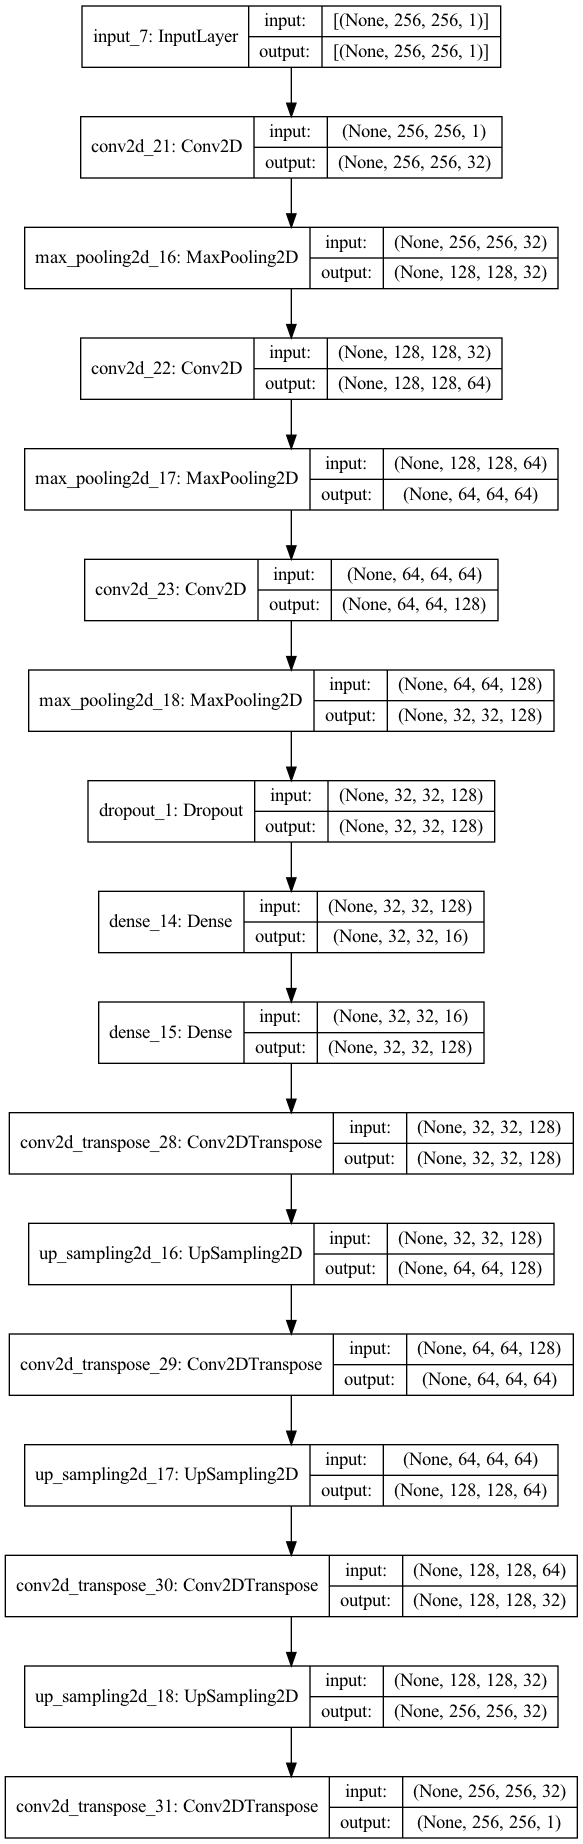

In [54]:
plot_model(ae_dropout, to_file='model5.png',show_shapes=True)

https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

In [55]:
callback = EarlyStopping(monitor='loss', patience=30)
history2 = ae_dropout.fit(noisy_input, pure, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])


Epoch 1/10
20/20 [==============================] - 36s 2s/step - loss: 0.0863 - mae: 0.2205 - val_loss: 0.1360 - val_mae: 0.3486
Epoch 2/10
20/20 [==============================] - 36s 2s/step - loss: 0.0208 - mae: 0.0863 - val_loss: 0.1220 - val_mae: 0.3306
Epoch 3/10
20/20 [==============================] - 36s 2s/step - loss: 0.0092 - mae: 0.0542 - val_loss: 0.1238 - val_mae: 0.3317
Epoch 4/10
20/20 [==============================] - 36s 2s/step - loss: 0.0063 - mae: 0.0450 - val_loss: 0.1239 - val_mae: 0.3305
Epoch 5/10
20/20 [==============================] - 36s 2s/step - loss: 0.0051 - mae: 0.0402 - val_loss: 0.1184 - val_mae: 0.3215
Epoch 6/10
20/20 [==============================] - 36s 2s/step - loss: 0.0041 - mae: 0.0356 - val_loss: 0.1128 - val_mae: 0.3129
Epoch 7/10
20/20 [==============================] - 36s 2s/step - loss: 0.0035 - mae: 0.0325 - val_loss: 0.1042 - val_mae: 0.2999
Epoch 8/10
20/20 [==============================] - 36s 2s/step - loss: 0.0031 - mae: 0.03

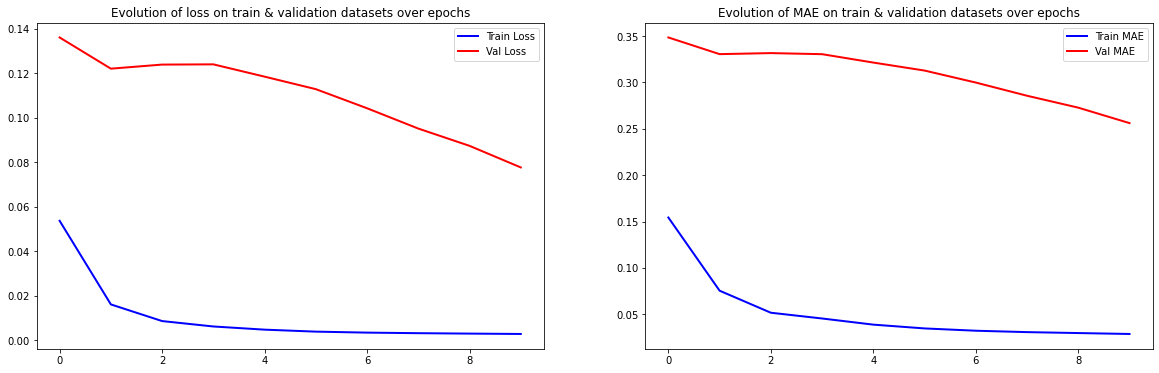

In [56]:
epoch_loss2 = history2.history['loss']
epoch_val_loss2 = history2.history['val_loss']
epoch_mae2 = history2.history['mae']
epoch_val_mae2 = history2.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss2)), epoch_loss2, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss2)), epoch_val_loss2, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae2)), epoch_mae2, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae2)), epoch_val_mae2, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

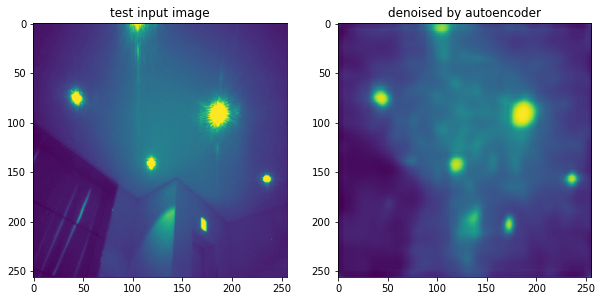

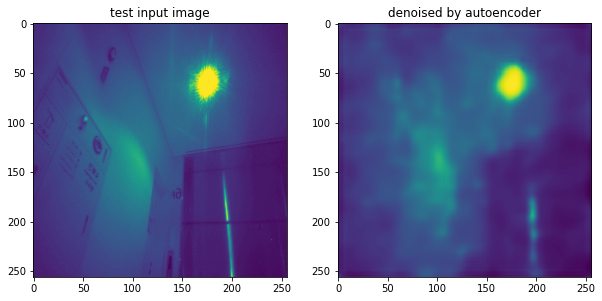

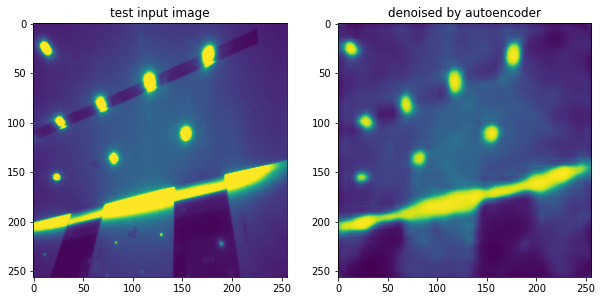

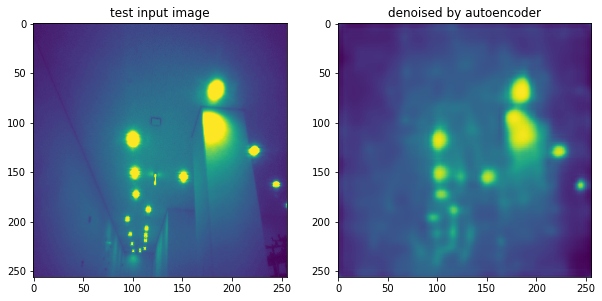

In [57]:
# plots
samples = noisy_input_test
targets = X_test
Y_test5 = ae_dropout.predict(samples, batch_size = 16)

for i in range(0, 4):
    inp_img = cv2.imread(train_input_files[i])
    inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize = (10, 7.2))
    fig.add_subplot(121)
    plt.title('test input image')
    plt.imshow(X_test[i])
    fig.add_subplot(122)
    plt.title('denoised by autoencoder')
    plt.imshow(Y_test5[i])
    plt.show

In [64]:
def ae_dropout2():
    input_layer = tensorflow.keras.layers.Input(shape=(256, 256, 1))
    encoder = tensorflow.keras.layers.Conv2D(32, 3, strides=2, padding="same", activation='relu')(input_layer)
    encoder = tensorflow.keras.layers.Conv2D(64, 3, strides=2, padding="same", activation='relu')(encoder)
    encoder = tensorflow.keras.layers.Conv2D(128, 3, strides=2, padding="same", activation='relu')(encoder)

    encoder = tensorflow.keras.layers.Dense(16)(encoder)
    encoder = Dropout(0.5)(encoder)
    decoder = Dense(128)(encoder)
    #decoder = Reshape((32, 32, 128))(decoder)
    #Model(input_layer, decoder).summary()
    decoder = tensorflow.keras.layers.Conv2DTranspose(64, 3,  strides=2, padding="same", activation='relu')(decoder)
    decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation='relu')(decoder)
    decoder = tensorflow.keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation='relu')(decoder)
    decoder_output = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(decoder)

    model = Model(inputs = [input_layer], outputs = [decoder_output])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model

ae_dropout2 = ae_dropout2()
ae_dropout2.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
dense_19 (Dense)             (None, 32, 32, 16)        2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
dense_20 (Dense)             (None, 32, 32, 128)       2176

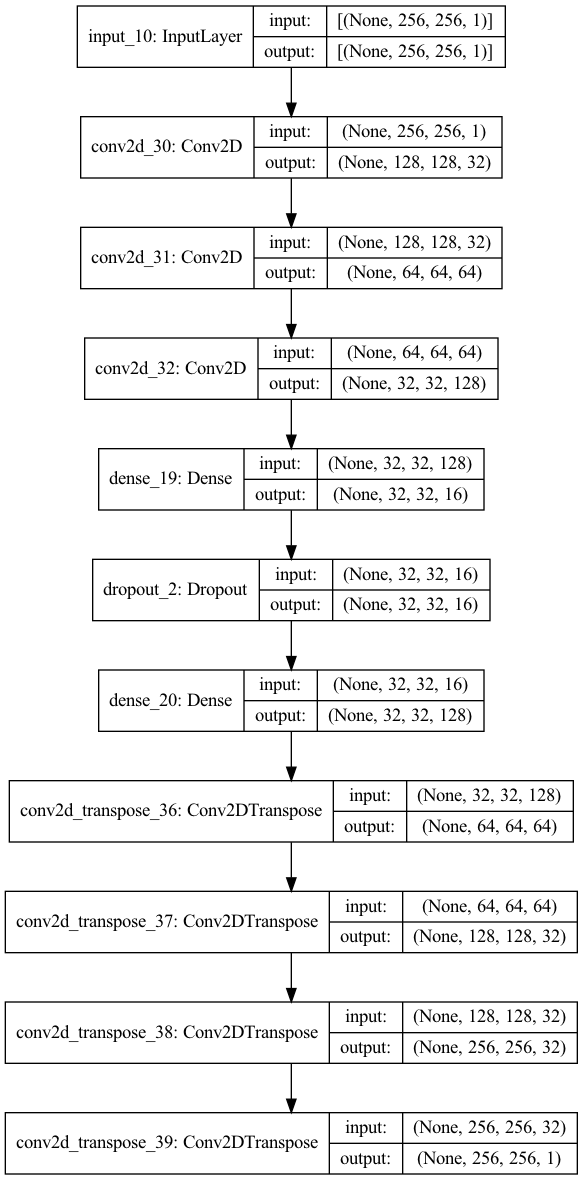

In [65]:
plot_model(ae_dropout2, to_file='model5.png',show_shapes=True)

In [66]:
callback = EarlyStopping(monitor='loss', patience=30)
history3 = ae_dropout2.fit(noisy_input, pure, validation_data = (X_val, Y_val), epochs=10, batch_size=24, verbose=1, callbacks=[callback])


Epoch 1/10
20/20 [==============================] - 19s 912ms/step - loss: 0.1461 - mae: 0.3557 - val_loss: 0.0842 - val_mae: 0.2680
Epoch 2/10
20/20 [==============================] - 17s 865ms/step - loss: 0.0263 - mae: 0.1027 - val_loss: 0.0774 - val_mae: 0.2525
Epoch 3/10
20/20 [==============================] - 17s 852ms/step - loss: 0.0226 - mae: 0.0829 - val_loss: 0.0710 - val_mae: 0.2461
Epoch 4/10
20/20 [==============================] - 17s 851ms/step - loss: 0.0195 - mae: 0.0716 - val_loss: 0.0682 - val_mae: 0.2424
Epoch 5/10
20/20 [==============================] - 17s 858ms/step - loss: 0.0197 - mae: 0.0714 - val_loss: 0.0626 - val_mae: 0.2316
Epoch 6/10
20/20 [==============================] - 17s 870ms/step - loss: 0.0151 - mae: 0.0625 - val_loss: 0.0533 - val_mae: 0.2118
Epoch 7/10
20/20 [==============================] - 17s 873ms/step - loss: 0.0057 - mae: 0.0458 - val_loss: 0.0488 - val_mae: 0.1946
Epoch 8/10
20/20 [==============================] - 18s 915ms/step - 

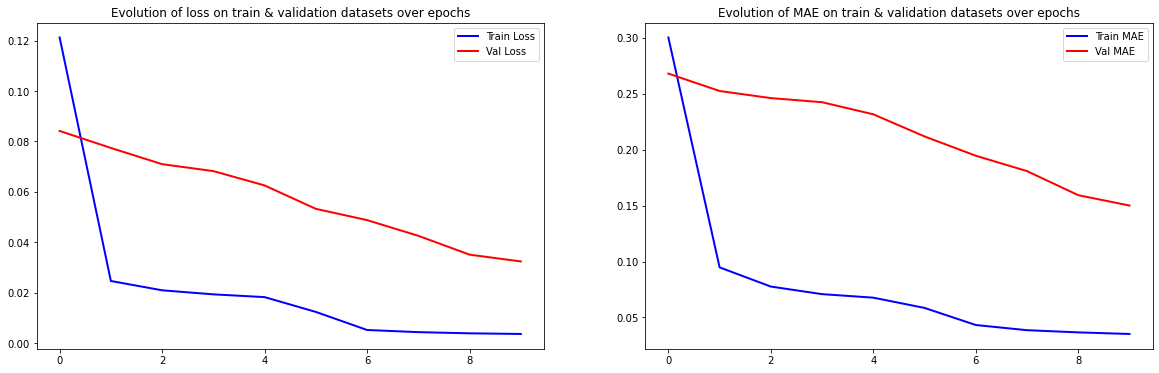

In [67]:
epoch_loss2 = history3.history['loss']
epoch_val_loss2 = history3.history['val_loss']
epoch_mae2 = history3.history['mae']
epoch_val_mae2 = history3.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss2)), epoch_loss2, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss2)), epoch_val_loss2, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae2)), epoch_mae2, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae2)), epoch_val_mae2, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

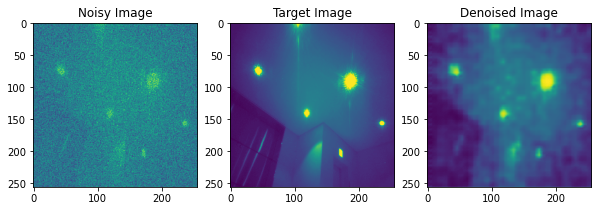

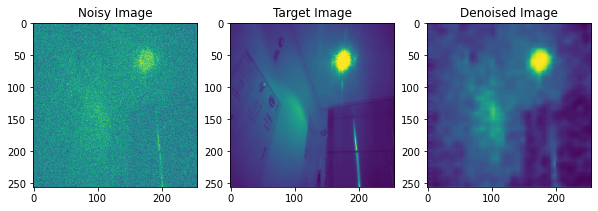

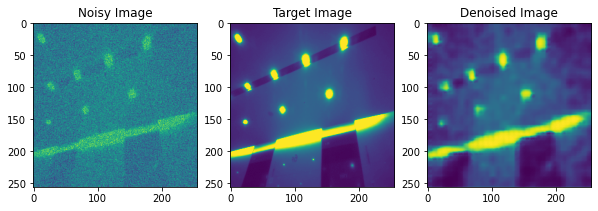

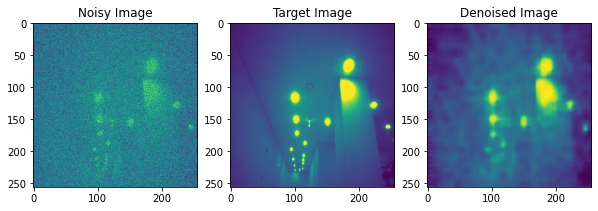

In [68]:
samples = noisy_input_test
targets = X_test
denoised_images = ae_dropout2.predict(samples)
# plots
for i in range(0, 4):
    fig = plt.figure(figsize = (10, 9.2))
    fig.add_subplot(131)
    plt.title('Noisy Image')
    plt.imshow(samples[i])
    fig.add_subplot(132)
    plt.title('Target Image')
    plt.imshow(targets[i])
    fig.add_subplot(133)
    plt.title('Denoised Image')
    plt.imshow(denoised_images[i])
    plt.show